In [1]:
from matplotlib.patches import Patch
import sys, time, math
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import sctmCP_Dec15_2023 as cellTraj
import cellCycRepJCtrajsCP as cellTrajCCR
from csaps import csaps
import string, pickle 
from datetime import date
from skimage import io, measure
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation

In [2]:
# Trajectory Length for morphodynamical trajectory analysis
trajl = 1
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day
#conditions = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)
#tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM2','EGF2','EGF+TGFB2','TGFB2','PBS2',
#         'OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
conditions = ['A2'] # LIGANDS (CONDITIONS)
tmSet = ['EGF1']
nConditions = len(tmSet) # Total number of Ligand Conditions
inds_tmSet = [i for i in range(nConditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
#nfovs = 4
nfovs = 1
fovs = [i for i in range(1, nfovs + 1)]
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(nConditions)]
modelList = [None]*(nfovs*(nConditions))
modelList_conditions = np.zeros(nfovs*(nConditions)).astype(int)

In [3]:
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        modelList_conditions[i] = icond
        modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fov)+dateSet[imagingSet[icond]]
        #print("Models: ",modelList[i])
        i = i + 1
    icond = icond + 1

In [4]:
nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print('loaded '+objFile+' with '+str(modelSet[i].cells_indSet.size)+' cells')
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/znormRegPhaseImgs/LI204601_P_A2_1.obj with 51054 cells


In [5]:
# Total number of frames (image snapshots) in one condition per FOVs
nframes = 193 
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*nframes/100.; sframe = math.ceil(sframe)
eframe = 98.5*nframes/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(nframes)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

for i in indgood_models:
    ncells = np.zeros(nframes)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(nframes):
        ncells[iS]=np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers

In [6]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
#indgood_models = np.setdiff1d(indgood_models, np.array([51]).astype(int)) #missing comdx for EGF0_4

# get cell counts
nf = len(tmSet)
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    for fov in fovs:
        inds_tmSet_models[i] = inds_tmSet[icond]
        inds_imagingSet_models[i] = imagingSet[icond]
        i = i + 1
    icond = icond + 1

In [7]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [8]:
wctm = cellTraj.Trajectory() # import Trajectory object 

nfeat = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0]))
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [9]:
# Use the sklearn package (intended for ease of use over performance/scalability)
varCutOff = 10 # changed from 10 to 6 to match with JC's notebook
from sklearn.decomposition import PCA 
# n_components specifies the number of principal components to extract from the covariance matrix
pca = PCA(n_components = varCutOff) 
pca.fit(Xf) # builds the covariance matrix and "fits" the principal components
Xpca = pca.transform(Xf) # transforms the data into the pca representation
nPCs = Xpca.shape[1]

In [10]:
wctm.Xpca = Xpca
wctm.pca = pca
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xpca = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [11]:
self = wctm
#wctm.trajl = trajl
all_trajSet = [None]*nmodels
for i in indgood_models:
    #modelSet[i].get_unique_trajectories(verbose = True)
    modelSet[i].get_unique_trajectories()

tracked cell 50900, 23 tracks, 47500 left
tracked cell 50701, 41 tracks, 41900 left
tracked cell 50625, 52 tracks, 39700 left
tracked cell 49059, 3 tracks, 38700 left
tracked cell 47575, 34 tracks, 38100 left
tracked cell 44782, 17 tracks, 36900 left
tracked cell 43429, 1 tracks, 36400 left
tracked cell 42537, 1 tracks, 36200 left
tracked cell 39844, 25 tracks, 34200 left
tracked cell 38077, 21 tracks, 32900 left
tracked cell 36361, 6 tracks, 31700 left
tracked cell 35482, 1 tracks, 31400 left
tracked cell 34248, 2 tracks, 31100 left
tracked cell 33966, 5 tracks, 31000 left
tracked cell 31034, 1 tracks, 30400 left
tracked cell 30880, 1 tracks, 30300 left
tracked cell 30574, 1 tracks, 30000 left
tracked cell 30191, 21 tracks, 28100 left
tracked cell 30076, 13 tracks, 26800 left
tracked cell 29967, 34 tracks, 26200 left
tracked cell 29646, 2 tracks, 25400 left
tracked cell 28784, 15 tracks, 24100 left
tracked cell 28276, 12 tracks, 23800 left
tracked cell 25762, 1 tracks, 22900 left
trac

In [12]:
for i in indgood_models:
    # Set of all single-cell trajectories with absolute (irrespective of frames) cell indices
    num_single_cell_trajs = len(modelSet[i].trajectories)
    
    single_cell_traj_lengths = []
    for itraj in range(num_single_cell_trajs):
        single_cell_traj_inds = modelSet[i].trajectories[itraj] # Indices of single-cell trajectory across frames
        single_cell_traj_length = len(single_cell_traj_inds) # Length of a single-cell trajectory
        single_cell_traj_lengths.append(single_cell_traj_length)  
    indtrajs = np.argsort(single_cell_traj_lengths) # Length ordered array of unique single-cell trajectories 

In [13]:
############ Find the longest single-cell trajectory ############
longest_trajectory = max(single_cell_traj_lengths) 
if longest_trajectory > nframes: 
    print("Error: longest single-cell trajectory can't exceed total number of frames")
    sys.exit(0)
#print("Longest single-cell trajectory length: ",longest_trajectory)
ind_longest_trajectory = np.argmax(single_cell_traj_lengths) # Index of the longest single-cell trajectory
#print("Index of longest single-cell trajectory: ",ind_longest_trajectory)
cell_inds_longest_traj = modelSet[i].trajectories[ind_longest_trajectory] # Cell indices
#print("Cell indices of the longest single-cell trajectory: ",cell_inds_longest_traj)

In [ ]:
# Make a plot of cell coordinate and single-cell images along a cell trajectory
def show_cell_trajectory(self, cell_traj, x = None, traj = None, nbins = 100): 
    if x is None:
        x = self.Xtraj
    if traj is None:
        traj = self.traj
    plt.figure(figsize = (12, 6))
    prob, xedges1, yedges1 = np.histogram2d(x[:, 0], x[:, 1], bins = nbins, density = True) # Coordinate landscape probability distribution
    xx, yy = np.meshgrid(.5*xedges1[1:] + .5*xedges1[0:-1], .5*yedges1[1:] + .5*yedges1[0:-1]) # Grid coordinates
    xt, inds_traj = self.get_Xtraj_celltrajectory(cell_traj, Xtraj = x, traj = traj) # Get coordinates & cell indices along a trajectory set
    cell_traj = self.traj[inds_traj,-1]
    nt = cell_traj.size # Total number of single-cell trajectories 
    icell = cell_traj[-1]
    for itt in range(nt):
        clear_output(wait = True)
        plt.clf()
        plt.subplot(1, 2, 1)
        # Single-cell trajectory distribution for a given snippet length
        cs = plt.contourf(xx, yy, prob.T, cmap = plt.cm.Greys, extend = 'both') 
        cs.cmap.set_over('black')
        plt.axis('off')
        ax = plt.gca()
        for ittt in range(itt - 1):
            ax.arrow(xt[ittt, 0], xt[ittt, 1], xt[ittt+1, 0] - xt[ittt, 0], xt[ittt+1, 1] - xt[ittt, 1],
                     head_width = .2, linewidth = 1.0, color = plt.cm.winter(ittt/nt), alpha = 1.0) # Along a selected trajectory
        plt.subplot(1, 2, 2)
        self.get_cellborder_images(indcells = np.array([cell_traj[itt]]), bordersize = 60) # Originally bordersize = 80, kept by JC
        imgcell = self.cellborder_imgs[0]
        mskcell = self.cellborder_msks[0]
        fmskcell = self.cellborder_fmsks[0]
        #ccborder, csborder = self.get_cc_cs_border(mskcell, fmskcell)
        plt.imshow(np.ma.masked_where(fmskcell == 0, imgcell), cmap = plt.cm.seismic, clim = (-5, 5), alpha = 1.0)
        plt.imshow(np.ma.masked_where(fmskcell == 1, imgcell), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
        nx = imgcell.shape[0]
        ny = imgcell.shape[1]
        xxc, yyc = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
        cmskx = np.sum(np.multiply(xxc, mskcell))/np.sum(mskcell)
        cmsky = np.sum(np.multiply(yyc, mskcell))/np.sum(mskcell)
        scatter_x = plt.scatter(cmsky, cmskx, s = 600, color = 'black', marker = 'x', alpha = 0.6)
        plt.axis('off')
        plt.pause(.33)

In [ ]:
model_indc = 0
modelSet[model_indc].trajl = 1
# Get trajectory segments of a given snippet length, to be consistent with trajectory embeddings
modelSet[model_indc].traj = modelSet[model_indc].get_traj_segments(1) 
cell_traj = modelSet[model_indc].trajectories[indtrajs[-10]]
show_cell_trajectory(modelSet[model_indc], cell_traj, x = modelSet[model_indc].Xpca[:, 0:2], traj = modelSet[model_indc].traj)

Concatenates PCA features along trajectories of length "trajl = traj_snip_length", and then embeds morphodynamical feature trajectory into a UMAP of dimension "neigen" = 2 

In [ ]:
trajl = 33 # 8 hrs
modelSet[model_indc].get_trajectory_embedding(trajl, embedding_type = 'UMAP', neigen = 2, get_trajectories = False)
show_cell_trajectory(modelSet[model_indc], modelSet[model_indc].trajectories[indtrajs[-10]], 
                     x = modelSet[model_indc].Xtraj, traj = modelSet[model_indc].traj)

In [ ]:
# Plot of cell coordinates and images along a single-cell trajectory
def show_single_cell_trajectory(self, cell_traj): 
    plt.figure(figsize = (8, 4))
    nt = cell_traj.size # Number of single-cell trajectory snippets
    
    for itt in range(nt):
        clear_output(wait = True)
        plt.clf()
        indcells = np.array([cell_traj[itt]]) # Index of a cell along its trajectory 
        fid = self.cells_frameSet[indcells]
        print("Frame: ",fid)
        self.get_cellborder_images(indcells = indcells, bordersize = 60) # Originally bordersize = 80, kept by JC
        imgcell = self.cellborder_imgs[0]
        mskcell = self.cellborder_msks[0]
        fmskcell = self.cellborder_fmsks[0]
        ccborder, csborder = self.get_cc_cs_border(mskcell, fmskcell)
        plt.imshow(np.ma.masked_where(fmskcell == 0, imgcell), cmap = plt.cm.seismic, clim = (-5, 5), alpha = 1.0)
        plt.imshow(np.ma.masked_where(fmskcell == 1, imgcell), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
        plt.imshow(np.ma.masked_where(ccborder == 1, mskcell, copy = False), cmap = plt.cm.viridis, alpha = 0.2)
        nx = imgcell.shape[0]
        ny = imgcell.shape[1]
        xxc, yyc = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
        cmskx = np.sum(np.multiply(xxc, mskcell))/np.sum(mskcell)
        cmsky = np.sum(np.multiply(yyc, mskcell))/np.sum(mskcell)
        plt.scatter(cmsky, cmskx, s = 600, color = 'black', marker = 'x', alpha = 0.6)
        plt.axis('off')
        plt.pause(.33)

In [ ]:
model_indc = 0
cell_traj = modelSet[model_indc].trajectories[indtrajs[-10]]
show_single_cell_trajectory(modelSet[model_indc], cell_traj)

In [ ]:
def anim_single_cell_trajectory(self, cell_traj, x=None):
    if x is None:
        x = self.Xtraj

    filename='single_cell_trajectory'
    fig, ax = plt.subplots(figsize=(8, 4))
    nt = cell_traj.size

    def update(itt):
        clear_output(wait=True)
        ax.clear()
        self.get_cellborder_images(indcells=np.array([cell_traj[itt]]), bordersize=60)
        imgcell = self.cellborder_imgs[0]
        mskcell = self.cellborder_msks[0]
        fmskcell = self.cellborder_fmsks[0]
        ccborder, csborder = self.get_cc_cs_border(mskcell, fmskcell)
        ax.imshow(np.ma.masked_where(fmskcell == 0, imgcell), cmap=plt.cm.seismic, clim=(-5, 5), alpha=1.0)
        ax.imshow(np.ma.masked_where(fmskcell == 1, imgcell), cmap=plt.cm.gray, clim=(-5, 5), alpha=0.6)
        ax.imshow(np.ma.masked_where(ccborder == 1, mskcell, copy=False), cmap=plt.cm.copper, alpha=0.25)
        nx, ny = imgcell.shape[0], imgcell.shape[1]
        xxc, yyc = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
        cmskx = np.sum(np.multiply(xxc, mskcell)) / np.sum(mskcell)
        cmsky = np.sum(np.multiply(yyc, mskcell)) / np.sum(mskcell)
        ax.scatter(cmsky, cmskx, s=600, color='black', marker='x', alpha=0.6)
        ax.axis('off')

    try:
        anim = FuncAnimation(fig, update, frames=nt, interval=330)
        #anim.save(filename+'.mp4', writer='ffmpeg')
        anim.save(filename+'.gif', writer='imagemagick')
        print(f"Animation saved as {filename}")
    except Exception as e:
        print(f"Error occurred: {e}")

    plt.close(fig)

In [ ]:
import matplotlib 
matplotlib.use('Agg')  # Use a non-interactive backend suitable for scripts
model_indc = 0
modelSet[model_indc].trajl = 1 
cell_traj = modelSet[model_indc].trajectories[indtrajs[-10]]
anim_single_cell_trajectory(modelSet[model_indc], cell_traj, x = modelSet[model_indc].Xpca[:, 0:2])

In [14]:
def cross_correlation(reporter_image_cropMasked, nuclear_image_cropMasked):

    # Flatten the images if they are 2D
    if reporter_image_cropMasked.ndim == 2:
        reporter_image_cropMasked = reporter_image_cropMasked.flatten()
    if nuclear_image_cropMasked.ndim == 2:
        nuclear_image_cropMasked = nuclear_image_cropMasked.flatten()
        
    # Compute correlation coefficient
    correlation_coefficient = np.corrcoef(reporter_image_cropMasked, nuclear_image_cropMasked)[0, 1]
    
    return correlation_coefficient

In [14]:
# Import single-cell trajectory model from cell-cycle reporter' class
sctm = cellTrajCCR.TrajectoryCCR()
sctm.visual = False
start_frame = 0
filepath = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/crossCorrCCRnuc/'

In [15]:
model = filepath+sysName+'_'+conditions[0]+'_1.h5'
print("Model name:", model)
# Load cell cycle reporter and nuclear images and cytoplasm masks
print('initializing...')
sctm.initialize(model, sysName)
# Get all the frames (193 at intervals of 15 minutes) for each model (condition)
sctm.get_frames()
end_frame = sctm.maxFrame
# Get the cell-cycle reporter image and the cytoplasmic mask
sctm.get_imageSet(start_frame, end_frame)
# Get nuclear channel images 
sctm.get_nucImgSet(start_frame, end_frame)
sctm.imgSet_t = np.zeros((end_frame - start_frame + 1, 3))
sctm.get_cell_data()
sctm.get_cell_images()

Model name: /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/crossCorrCCRnuc/LI204601_P_A2_1.h5
initializing...
Frame 0 has 1 images...
Frame 1 has 1 images...
Frame 2 has 1 images...
Frame 3 has 1 images...
Frame 4 has 1 images...
Frame 5 has 1 images...
Frame 6 has 1 images...
Frame 7 has 1 images...
Frame 8 has 1 images...
Frame 9 has 1 images...
Frame 10 has 1 images...
Frame 11 has 1 images...
Frame 12 has 1 images...
Frame 13 has 1 images...
Frame 14 has 1 images...
Frame 15 has 1 images...
Frame 16 has 1 images...
Frame 17 has 1 images...
Frame 18 has 1 images...
Frame 19 has 1 images...
Frame 20 has 1 images...
Frame 21 has 1 images...
Frame 22 has 1 images...
Frame 23 has 1 images...
Frame 24 has 1 images...
Frame 25 has 1 images...
Frame 26 has 1 images...
Frame 27 has 1 images...
Frame 28 has 1 images...
Frame 29 has 1 images...
Frame 30 has 1 images...
Frame 31 has 1 images...
Frame 32 has 1 images...
Frame 33 has 1 images...
Frame 34 has 1 images...
Frame 35 has 1 images.

In [77]:
###################### To save as an animation ########################
model_indc = 0
tid = 58 # Trajectory number from the end of the array 
save_file_indc = indtrajs[-tid]
cell_traj = modelSet[model_indc].trajectories[indtrajs[-tid]]
#### Plot of cell coordinates and images along a single-cell trajectory #### 
border_margin = 2
nt = cell_traj.size # Number of single-cell trajectory snippets
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
fig.tight_layout()  # Adjust subplots to fit into the figure area
frames_traj = []
cross_corr = []
def update(itt):
    clear_output(wait = True)
    for ax in axs:
        ax.clear()
    #fig, axs = plt.subplots(1, 4, figsize = (24, 5))
    indcells = np.array([cell_traj[itt]]) # Index of a cell along its trajectory 
    fid = modelSet[model_indc].cells_frameSet[indcells[0]]
    # Originally bordersize = 80, kept by JC
    modelSet[model_indc].get_single_cell_borders(indcells = indcells[0], bordersize = border_margin) 
    imgcell = modelSet[model_indc].cellborder_imgs[0]
    mskcell = modelSet[model_indc].cellborder_msks[0]
    fmskcell = modelSet[model_indc].cellborder_fmsks[0]
    ccborder, csborder = modelSet[model_indc].get_cc_cs_border(mskcell, fmskcell)
    
    axs[0].imshow(np.ma.masked_where(fmskcell == 0, imgcell), cmap = plt.cm.seismic, clim = (-5, 5), alpha = 1.0)
    axs[0].imshow(np.ma.masked_where(fmskcell == 1, imgcell), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
    axs[0].imshow(np.ma.masked_where(ccborder == 1, mskcell, copy = False), cmap = plt.cm.viridis, alpha = 0.2)
    nx = imgcell.shape[0]
    ny = imgcell.shape[1]
    xxc, yyc = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
    cmskx = np.sum(np.multiply(xxc, mskcell))/np.sum(mskcell)
    cmsky = np.sum(np.multiply(yyc, mskcell))/np.sum(mskcell)
    axs[0].scatter(cmsky, cmskx, s = 1000, color = 'black', marker = 'x', alpha = 0.6)
    axs[0].axis('off')
    
    reporter_image = sctm.imgSet[fid] # Cell cycle reporter image 
    nuclear_image = sctm.nucImgSet[fid] # Nuclear channel image
    reporter_image = np.array(reporter_image)   
    nuclear_image = np.array(nuclear_image)
    x_min = modelSet[model_indc].xmin
    y_min = modelSet[model_indc].ymin
    x_max = modelSet[model_indc].xmax
    y_max = modelSet[model_indc].ymax
   
    # Crop the reporter and nuclear images as per the cell mask 
    cropped_reporter_image = reporter_image[x_min:x_max, y_min:y_max]
    cropped_nuclear_image = nuclear_image[x_min:x_max, y_min:y_max]
    # Calculate cross-correlation between cell-cycle reporter and nuclear channel images 
    cross_corr_frame = cross_correlation(cropped_reporter_image, cropped_nuclear_image)
    cross_corr.append(cross_corr_frame)
    frames_traj.append(fid)
    axs[1].imshow(np.ma.masked_where(mskcell == 0, cropped_reporter_image, copy = False), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
    axs[1].set_title('Reporter channel')
    axs[1].axis('off')
    axs[2].imshow(np.ma.masked_where(mskcell == 0, cropped_nuclear_image, copy = False), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
    axs[2].set_title('Nuclear channel')
    axs[2].axis('off')
    axs[3].plot(frames_traj, cross_corr, color = 'b', marker = 'o', markersize = 8, markerfacecolor = 'k')
    axs[3].set_xlabel('Frames')
    axs[3].set_ylabel('Cross-correlation b/w reporter and nuclear channel')
    # After updating the content, reapply tight layout
    fig.tight_layout()
    return axs
########################################## CALL TO SAVE IMAGES AS AN ANIMATION ##########################################
anim = FuncAnimation(fig, update, frames=nt, interval=330)
filename = 'single_cell_trajectory_EGFTGFB'+str(save_file_indc)+'.gif'
anim.save(filename, writer='pillow')
print(f"Animation saved as {filename}")
plt.close(fig)

extracting cellborders from frame 139 image 0
Animation saved as single_cell_trajectory_EGFTGFB1534.gif


<Figure size 640x480 with 0 Axes>

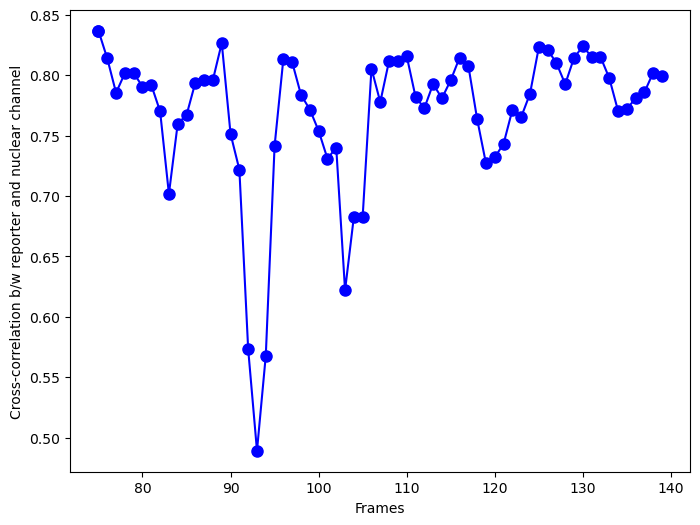

In [78]:
plt.clf()
plt.figure(figsize = (8, 6))
plt.plot(frames_traj, cross_corr, color = 'b', marker = 'o', markersize = 8)
plt.xlabel('Frames')
plt.ylabel('Cross-correlation b/w reporter and nuclear channel')
plt.show()

extracting cellborders from frame 139 image 0


<Figure size 640x480 with 0 Axes>

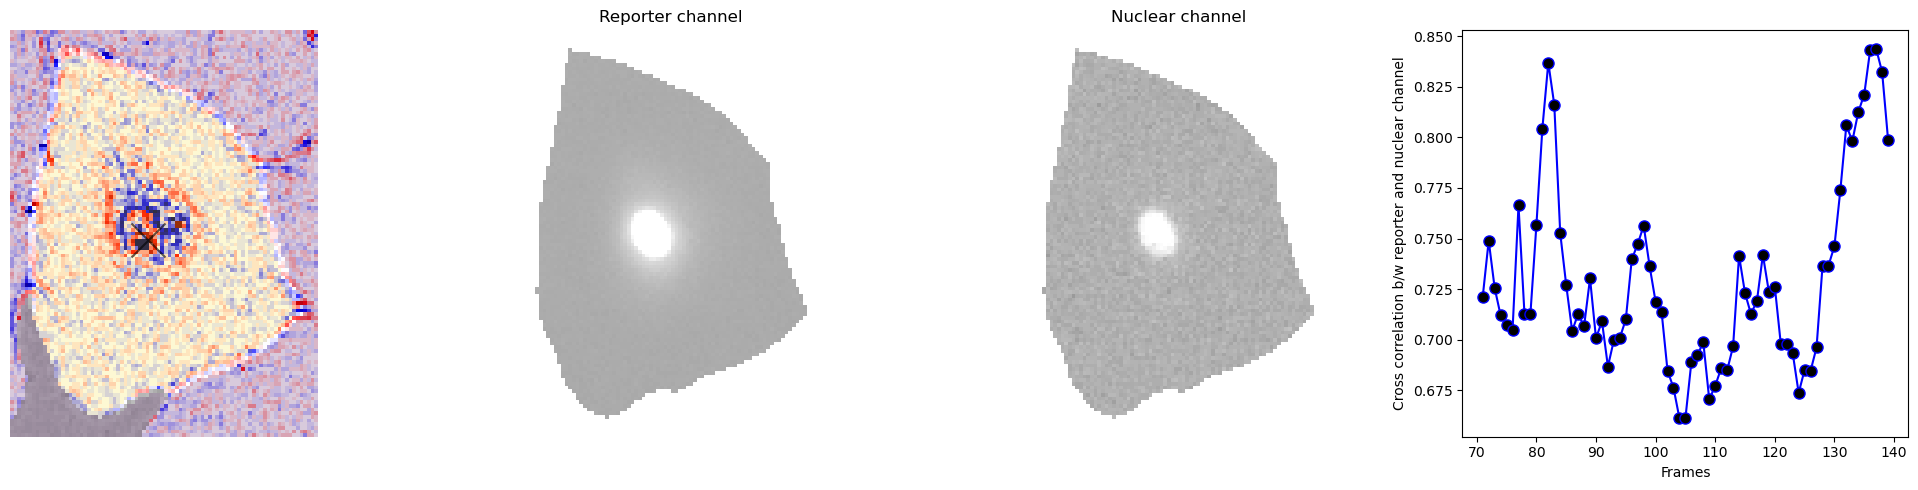

In [35]:
model_indc = 0
cell_traj = modelSet[model_indc].trajectories[indtrajs[-50]]

#### Plot of cell coordinates and images along a single-cell trajectory #### 
border_margin = 5
nt = cell_traj.size # Number of single-cell trajectory snippets
frames = []
cross_corr = []
for itt in range(nt):
    clear_output(wait = True)
    plt.clf()
    fig, axs = plt.subplots(1, 4, figsize = (20, 5))
    indcells = np.array([cell_traj[itt]]) # Index of a cell along its trajectory 
    fid = modelSet[model_indc].cells_frameSet[indcells[0]]
    # Originally bordersize = 80, kept by JC
    modelSet[model_indc].get_single_cell_borders(indcells = indcells[0], bordersize = border_margin) 
    imgcell = modelSet[model_indc].cellborder_imgs[0]
    mskcell = modelSet[model_indc].cellborder_msks[0]
    fmskcell = modelSet[model_indc].cellborder_fmsks[0]
    ccborder, csborder = modelSet[model_indc].get_cc_cs_border(mskcell, fmskcell)

    axs[0].imshow(np.ma.masked_where(fmskcell == 0, imgcell), cmap = plt.cm.seismic, clim = (-5, 5), alpha = 1.0)
    axs[0].imshow(np.ma.masked_where(fmskcell == 1, imgcell), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
    axs[0].imshow(np.ma.masked_where(ccborder == 1, mskcell, copy = False), cmap = plt.cm.viridis, alpha = 0.2)
    nx = imgcell.shape[0]
    ny = imgcell.shape[1]
    xxc, yyc = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')
    cmskx = np.sum(np.multiply(xxc, mskcell))/np.sum(mskcell)
    cmsky = np.sum(np.multiply(yyc, mskcell))/np.sum(mskcell)
    axs[0].scatter(cmsky, cmskx, s = 600, color = 'black', marker = 'x', alpha = 0.6)
    axs[0].axis('off')
    
    reporter_image = sctm.imgSet[fid] # Cell cycle reporter image 
    nuclear_image = sctm.nucImgSet[fid] # Nuclear channel image
    reporter_image = np.array(reporter_image)   
    nuclear_image = np.array(nuclear_image)
    x_min = modelSet[model_indc].xmin
    y_min = modelSet[model_indc].ymin
    x_max = modelSet[model_indc].xmax
    y_max = modelSet[model_indc].ymax
   
    # Crop the reporter and nuclear images as per the cell mask 
    cropped_reporter_image = reporter_image[x_min:x_max, y_min:y_max]
    cropped_nuclear_image = nuclear_image[x_min:x_max, y_min:y_max]
    # Calculate cross-correlation between cell-cycle reporter and nuclear channel images 
    cross_corr_frame = cross_correlation(cropped_reporter_image, cropped_nuclear_image)
    cross_corr.append(cross_corr_frame)
    frames.append(fid)
    axs[1].imshow(np.ma.masked_where(mskcell == 0, cropped_reporter_image), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
    axs[1].set_title('Reporter channel')
    axs[1].axis('off')
    axs[2].imshow(np.ma.masked_where(mskcell == 0, cropped_nuclear_image), cmap = plt.cm.gray, clim = (-5, 5), alpha = 0.6)
    axs[2].set_title('Nuclear channel')
    axs[2].axis('off')
    axs[3].plot(frames, cross_corr, color = 'b', marker = 'o', markersize = 8, markerfacecolor = 'k')
    axs[3].set_xlabel('Frames')
    axs[3].set_ylabel('Cross correlation b/w reporter and nuclear channel')
    fig.tight_layout()  # Adjust subplots to fit into the figure area
    plt.show()
    plt.pause(0.33)

In [ ]:
file_dump = sysName+'_cell_cycRep_'+date2day+'OSM1_regs'+str(single_cell_traj_test_ind)+'.dat'